The purpose of this notebook is to train a model that can be used to predict the type of shark. The data is collected from [Bing Image Search API](https://www.microsoft.com/en-us/bing/apis/bing-image-search-api) by Microsoft. Or, you can visit [this link](https://drive.google.com/drive/folders/1rfRy9Wxdw5BYQvGfrYKjnx3QPGEbqYcS?usp=sharing) to see the data that I used to train this model. 

# Import Libraries

In [ ]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 5.3 MB/s 
     |████████████████████████████████| 46 kB 2.9 MB/s 
     |████████████████████████████████| 1.2 MB 33.0 MB/s 
     |████████████████████████████████| 189 kB 36.3 MB/s 
     |████████████████████████████████| 56 kB 4.1 MB/s 
     |████████████████████████████████| 51 kB 273 kB/s 


In [ ]:
#hide
from fastbook import *
from fastai.vision.widgets import *

# Get the Data
To download images with Bing Image Search, sign up at [Microsoft Azure](https://azure.microsoft.com/en-us/services/cognitive-services/bing-web-search-api/) for a free account. You will be given a key, which you can copy and enter in a cell as follows (replacing 'XXX' with your key and executing it):

In [ ]:
import os
key = os.environ.get('AZURE_SEARCH_KEY', 'XXX')

In [ ]:
results = search_images_bing(key, 'shark')
ims = results.attrgot('contentUrl')
len(ims)

150

In [ ]:
dest = '/content/drive/MyDrive/Colab Notebooks/images/whiteshark.jpg'
download_url(ims[0], dest)

Path('/content/drive/MyDrive/Colab Notebooks/images/whiteshark.jpg')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


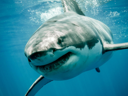

In [ ]:
im = Image.open(dest)
im.to_thumb(128,128)

In [ ]:
shark_types = 'white','hammerhead','orcinus orca'
path = Path('/content/drive/MyDrive/Colab Notebooks/sharks')

In [ ]:
if not path.exists():
    path.mkdir()
    for o in shark_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} shark')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [ ]:
fns = get_image_files(path)
fns

(#435) [Path('/content/drive/MyDrive/Colab Notebooks/sharks/white/00000007.jpg'),Path('/content/drive/MyDrive/Colab Notebooks/sharks/white/00000001.jpg'),Path('/content/drive/MyDrive/Colab Notebooks/sharks/white/00000000.jpg'),Path('/content/drive/MyDrive/Colab Notebooks/sharks/white/00000006.jpg'),Path('/content/drive/MyDrive/Colab Notebooks/sharks/white/00000004.jpg'),Path('/content/drive/MyDrive/Colab Notebooks/sharks/white/00000003.jpeg'),Path('/content/drive/MyDrive/Colab Notebooks/sharks/white/00000008.jpg'),Path('/content/drive/MyDrive/Colab Notebooks/sharks/white/00000010.jpg'),Path('/content/drive/MyDrive/Colab Notebooks/sharks/white/00000011.jpg'),Path('/content/drive/MyDrive/Colab Notebooks/sharks/white/00000014.jpg')...]

In [ ]:
failed = verify_images(fns)
failed

(#3) [Path('/content/drive/MyDrive/Colab Notebooks/sharks/hammerhead/00000004.png'),Path('/content/drive/MyDrive/Colab Notebooks/sharks/hammerhead/00000095.jpg'),Path('/content/drive/MyDrive/Colab Notebooks/sharks/orcinus orca/00000100.jpg')]

In [ ]:
failed.map(Path.unlink);

# From Data to DataLoaders

In [ ]:
sharks = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.3, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))


In [ ]:
dls = sharks.dataloaders(path)

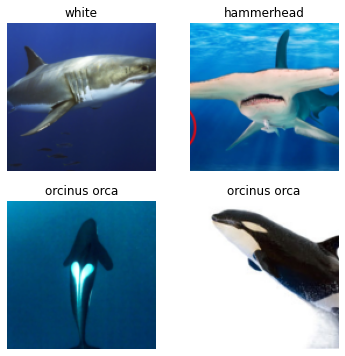

In [ ]:
dls.valid.show_batch(max_n=4, nrows=2)

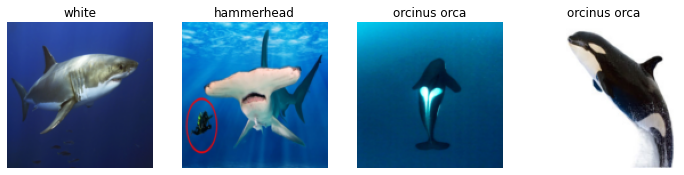

In [ ]:
sharks = sharks.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = sharks.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

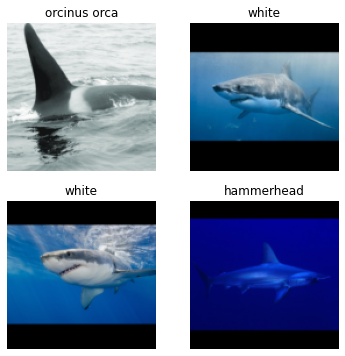

In [ ]:
sharks = sharks.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = sharks.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=2)

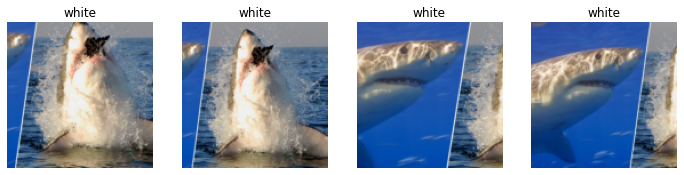

In [ ]:
sharks = sharks.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = sharks.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

# Data Augmentation

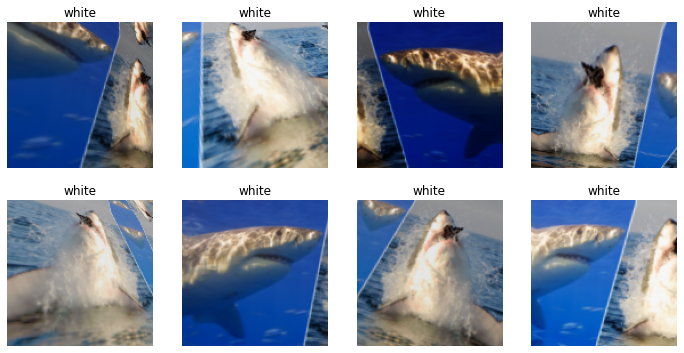

In [ ]:
sharks = sharks.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = sharks.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

# Training Model
Using It to Clean the Data

In [ ]:
sharks = sharks.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = sharks.dataloaders(path)

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch,train_loss,valid_loss,error_rate,time
0,1.628444,0.662611,0.302326,00:23


epoch,train_loss,valid_loss,error_rate,time
0,0.773605,0.468933,0.193798,00:22
1,0.553075,0.331062,0.131783,00:23
2,0.435217,0.293666,0.131783,00:23
3,0.359557,0.294710,0.116279,00:23


In [ ]:
resnet18??

Object `resnet18` not found.


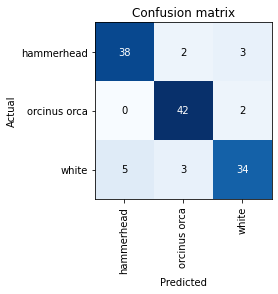

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

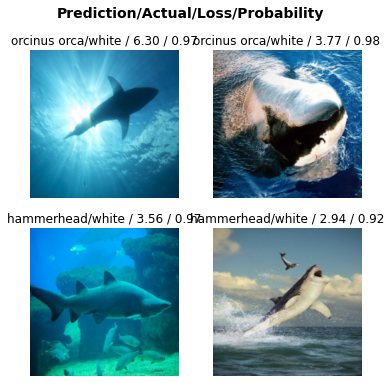

In [ ]:
interp.plot_top_losses(4, nrows=2)

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
#hide
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

# Using the Model for Inference

In [ ]:
learn.export()

In [ ]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [ ]:
learn_inf = load_learner(path/'export.pkl')

In [ ]:
learn_inf.predict('/content/hiu martil.jfif')

In [ ]:
learn_inf.dls.vocab

['hammerhead', 'orcinus orca', 'white']

# Creating a Notebook App from the Model

In [ ]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [ ]:
#hide
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['/content/hiu martil.jfif'])

In [ ]:
img = PILImage.create(btn_upload.data[-1])

In [ ]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [ ]:
pred,pred_idx,probs = learn_inf.predict(img)

In [ ]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: hammerhead; Probability: 0.9960')

In [ ]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [ ]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(328,328))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [ ]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [ ]:
VBox([widgets.Label('Unggah foto hiu/paus pembunuh mu!'), 
      btn_upload, btn_run, out_pl, lbl_pred])